In [1]:
from pathlib import Path
import pandas as pd
import re
from source.analyze.count_bigrams import describe_counts
from utils import print_iter, print_md_table

In [2]:
FREQ_OUT = Path('/share/compling/projects/sanpi/results/freq_out')
N_FILES = 35
THR_DEC_STR = '001'

In [3]:
def locate_freq_tables():
    meta_tag = f'thr0-{THR_DEC_STR}p.{N_FILES}f'
    print('# Comparing Bigram Frequencies\n',
        f'- for `{N_FILES}` corpus input `.conll` directories containing source `.conllu` files', 
        f'- with word types limited to only those that account for at least $0.{THR_DEC_STR}\%$ of the cleaned dataset (as sourced from {N_FILES} corpus file inputs) ', 
        f'- file identifier = `{meta_tag}`',
        sep='\n')
    neg_frq_pkl = FREQ_OUT.joinpath(
        f'RBdirect/all-frq_adj-x-adv_{meta_tag}.pkl.gz')
    if not neg_frq_pkl.is_file():
        print('⚠️ Path to directly negated bigrams frequency table not found.')
    try: 
        all_frq_pkl = list(FREQ_OUT.joinpath('RBXadj').glob(
            f'all_adj-x-adv_frq-{meta_tag}*.pkl.gz'))[0]
    except IndexError: 
        print('⚠️ Path to all bigrams frequency table not found.')

    global_count_floor = re.search(r'=(\d+)\+', all_frq_pkl.stem).groups()[0]
    print(
        '- pattern matches restricted to only token word types with',
        f'at least `{global_count_floor}` total tokens across all combinations')
    return all_frq_pkl, neg_frq_pkl

In [4]:
all_frq_pkl, neg_frq_pkl = locate_freq_tables()

# Comparing Bigram Frequencies

- for `35` corpus input `.conll` directories containing source `.conllu` files
- with word types limited to only those that account for at least $0.001\%$ of the cleaned dataset (as sourced from 35 corpus file inputs) 
- file identifier = `thr0-001p.35f`
- pattern matches restricted to only token word types with at least `868` total tokens across all combinations


# Comparing Bigram Frequencies

- for `35` corpus input `.conll` directories containing source `.conllu` files
- with word types limited to only those that account for at least $0.001\%$ of the cleaned dataset (as sourced from 35 corpus file inputs) 
- file identifier = `thr0-001p.35f`
- pattern matches restricted to only token word types with at least `868` total tokens across all combinations

## _Negated_ Frequencies Overview


## Descriptive Statistics for `adj_form_lower` by `adv_form_lower`


~ Saving adv_form_lower descriptive statististics for stats_all-frq_adj-x-adv_thr0-001p.35f. as csv...
   >> successfully saved as /share/compling/projects/sanpi/results/freq_out/RBdirect/descriptive_stats/ADV-stats_all-frq_adj-x-adv_thr0-001p.35f..csv
      (time elapsed: 00:00:00.380)

Sample adv_form_lower Stats 
| adv_form_lower   |   count |   mean |   std |   min |   25% |   50% |   75% |   max |   total |   var_coeff |   range |   IQ_range |   upper_fence |   lower_fence |   plus1_geo_mean |   plus1_har_mean |
|:-----------------|--------:|-------:|------:|------:|------:|------:|------:|------:|--------:|------------:|--------:|-----------:|--------------:|--------------:|-----------------:|-----------------:|
| tragically       |   3,886 |      0 |     0 |     0 |     0 |     0 |     0 |     4 |      55 |          11 |       4 |          0 |             0 |             0 |                1 |                1 |
| early            |   3,886 |      0 |     1 |     0 |     0 |    

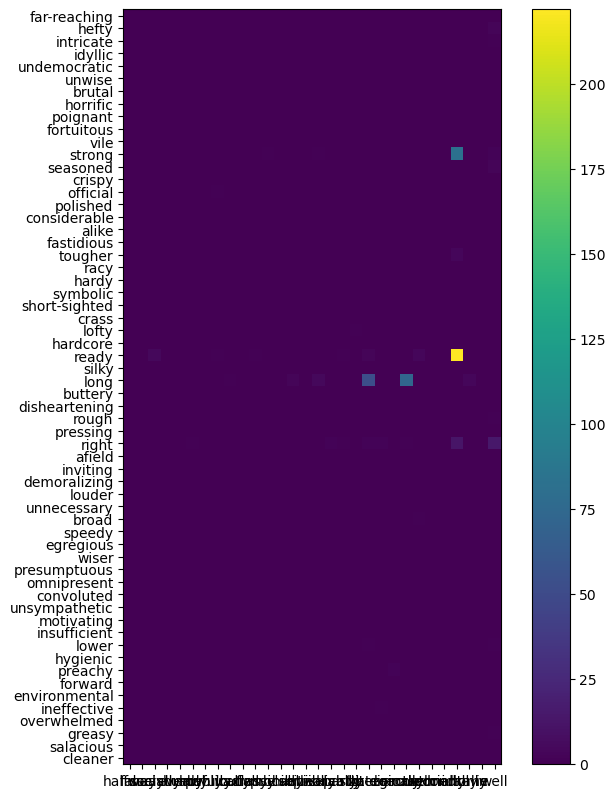

Heatmap saved to:
  /share/compling/projects/sanpi/results/freq_out/RBdirect/images/sample-heatmap_all-frq_adj-x-adv_thr0-001p.35f.pkl.png


<Figure size 432x288 with 0 Axes>

In [5]:
neg_frq = pd.read_pickle(neg_frq_pkl)
describe_counts(df=neg_frq, df_path=neg_frq_pkl)

### _Negated Frequencies_:  Descriptive Statistics for `adv_form_lower` by `adj_form_lower`

Sample `adv_form_lower` Stats 
| `adv_form_lower`       |   count |   mean |   std |   min |   25% |   50% |   75% |   max |   total |   var_coeff |   range |   IQ_range |   upper_fence |   lower_fence |   plus1_geo_mean |   plus1_har_mean |
|:---------------------|--------:|-------:|------:|------:|------:|------:|------:|------:|--------:|------------:|--------:|-----------:|--------------:|--------------:|-----------------:|-----------------:|
| linguistically       |   3,886 |      0 |     0 |     0 |     0 |     0 |     0 |     5 |      27 |          17 |       5 |          0 |             0 |             0 |                1 |                1 |
| along                |   3,886 |      0 |     0 |     0 |     0 |     0 |     0 |     9 |      18 |          34 |       9 |          0 |             0 |             0 |                1 |                1 |
| indirectly           |   3,886 |      0 |     0 |     0 |     0 |     0 |     0 |     8 |      14 |          38 |       8 |          0 |             0 |             0 |                1 |                1 |
| virulently           |   3,886 |      0 |     0 |     0 |     0 |     0 |     0 |     2 |      13 |          20 |       2 |          0 |             0 |             0 |                1 |                1 |
| uncharacteristically |   3,886 |      0 |     0 |     0 |     0 |     0 |     0 |     1 |      10 |          20 |       1 |          0 |             0 |             0 |                1 |                1 |
| clearly              |   3,886 |      0 |     6 |     0 |     0 |     0 |     0 |   324 |   1,449 |          17 |     324 |          0 |             0 |             0 |                1 |                1 |

 
|             |   Summed Across `adv_form_lower`s |
|:------------|--------------------------------:|
| count       |                           3,886 |
| mean        |                             811 |
| std         |                           4,758 |
| min         |                               1 |
| 25%         |                              35 |
| 50%         |                              88 |
| 75%         |                             298 |
| max         |                         132,519 |
| total       |                       3,151,853 |
| var_coeff   |                               6 |
| range       |                         132,518 |
| IQ_range    |                             263 |
| upper_fence |                             692 |
| lower_fence |                            -360 |

### _Negated Frequencies_:  Descriptive Statistics for `adv_form_lower` by `adj_form_lower`

Sample `adj_form_lower` Stats 
| `adj_form_lower`   |   count |   mean |   std |   min |   25% |   50% |   75% |   max |   total |   var_coeff |   range |   IQ_range |   upper_fence |   lower_fence |   plus1_geo_mean |   plus1_har_mean |
|:-----------------|--------:|-------:|------:|------:|------:|------:|------:|------:|--------:|------------:|--------:|-----------:|--------------:|--------------:|-----------------:|-----------------:|
| specious         |   1,001 |      0 |     0 |     0 |     0 |     0 |     0 |     6 |      26 |          10 |       6 |          0 |             0 |             0 |                1 |                1 |
| skimpy           |   1,001 |      0 |     1 |     0 |     0 |     0 |     0 |    23 |      45 |          17 |      23 |          0 |             0 |             0 |                1 |                1 |
| homophobic       |   1,001 |      0 |     1 |     0 |     0 |     0 |     0 |    17 |     122 |           8 |      17 |          0 |             0 |             0 |                1 |                1 |
| purposeful       |   1,001 |      0 |     0 |     0 |     0 |     0 |     0 |     8 |      56 |           9 |       8 |          0 |             0 |             0 |                1 |                1 |
| airy             |   1,001 |      0 |     1 |     0 |     0 |     0 |     0 |    26 |      60 |          16 |      26 |          0 |             0 |             0 |                1 |                1 |
| conclusive       |   1,001 |      1 |     6 |     0 |     0 |     0 |     0 |   129 |     694 |           9 |     129 |          0 |             0 |             0 |                1 |                1 |

 
|             |   Summed Across `adj_form_lower`s |
|:------------|--------------------------------:|
| count       |                           1,001 |
| mean        |                           3,149 |
| std         |                          25,356 |
| min         |                               1 |
| 25%         |                              16 |
| 50%         |                              50 |
| 75%         |                             206 |
| max         |                         527,495 |
| total       |                       3,151,853 |
| var_coeff   |                               8 |
| range       |                         527,494 |
| IQ_range    |                             190 |
| upper_fence |                             491 |
| lower_fence |                            -269 |


### Full Table Preview of _Negated_ Frequencies

In [6]:
neg_frq

adv_form_lower,SUM,as,so,too,very,more,that,only,always,really,...,faster,preposterously,doubtless,preferably,alternately,repeatedly,wondrously,seductively,fewer,unseasonably
adj_form_lower,,,,,,,,,,,,,,,,,,,,,
SUM,3151853,527495,341379,308112,191295,166307,165334,110007,103552,95582,...,2,2,1,1,1,1,1,1,1,1
good,132519,44998,18026,3631,30415,32,10683,3332,1711,2527,...,0,0,0,0,0,0,0,0,0,0
sure,128813,715,26602,8101,676,142,300,24,1169,17906,...,0,0,0,0,0,0,0,0,0,0
bad,105249,27766,21376,19532,317,8,16559,679,916,720,...,0,0,0,0,0,0,0,0,0,0
easy,87572,23393,17611,1207,2736,147,10170,1351,24592,544,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
personalised,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
immigrant,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
later,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## _All_ (negated and non-negated) Frequencies Overview


## Descriptive Statistics for `adj_form_lower` by `adv_form_lower`


~ Saving adv_form_lower descriptive statististics for stats_all_adj-x-adv_frq-thr0-001p.35f=868+. as csv...
   >> successfully saved as /share/compling/projects/sanpi/results/freq_out/RBXadj/descriptive_stats/ADV-stats_all_adj-x-adv_frq-thr0-001p.35f=868+..csv
      (time elapsed: 00:00:00.145)

Sample adv_form_lower Stats 
| adv_form_lower   |   count |   mean |   std |   min |   25% |   50% |   75% |   max |   total |   var_coeff |   range |   IQ_range |   upper_fence |   lower_fence |   plus1_geo_mean |   plus1_har_mean |
|:-----------------|--------:|-------:|------:|------:|------:|------:|------:|------:|--------:|------------:|--------:|-----------:|--------------:|--------------:|-----------------:|-----------------:|
| symbolically     |   3,894 |      0 |    11 |     0 |     0 |     0 |     0 |   643 |   1,733 |          25 |     643 |          0 |             0 |             0 |                1 |                1 |
| mightily         |   3,894 |      0 |     5 |     0 |    

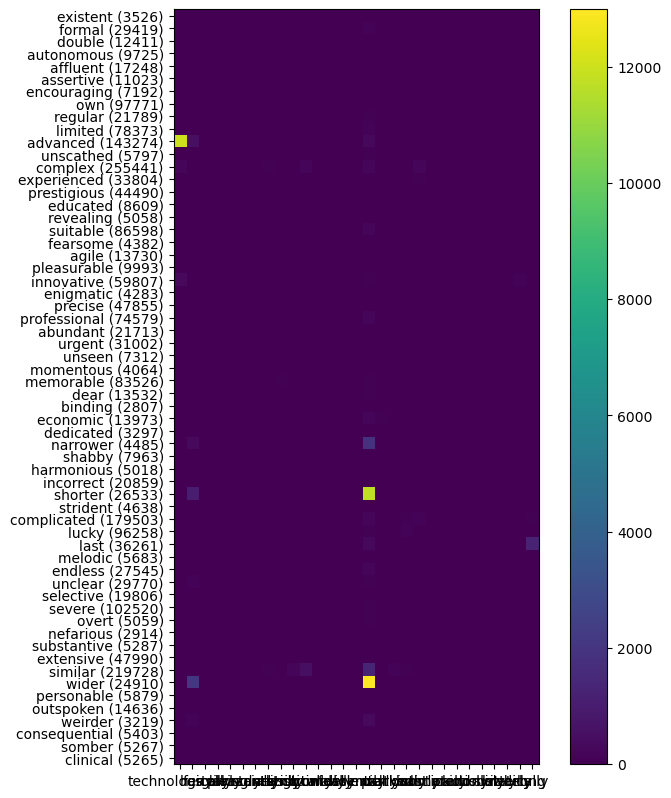

Heatmap saved to:
  /share/compling/projects/sanpi/results/freq_out/RBXadj/images/sample-heatmap_all_adj-x-adv_frq-thr0-001p.35f=868+.pkl.png


<Figure size 432x288 with 0 Axes>

In [7]:
all_frq = pd.read_pickle(all_frq_pkl)
describe_counts(all_frq, all_frq_pkl)

### _All Frequencies_: Descriptive Statistics for `adj_form_lower` by `adv_form_lower`


Sample `adv_form_lower` Stats 
| `adv_form_lower`   |   count |   mean |   std |   min |   25% |   50% |   75% |    max |     total |   var_coeff |   range |   IQ_range |   upper_fence |   lower_fence |   plus1_geo_mean |   plus1_har_mean |
|:-----------------|--------:|-------:|------:|------:|------:|------:|------:|------:|--------:|------------:|--------:|-----------:|--------------:|--------------:|-----------------:|-----------------:|
| momentarily      |   3,894 |      1 |     3 |     0 |     0 |     0 |     0 |   128 |   2,065 |           6 |     128 |          0 |             0 |             0 |                1 |                1 |
| laughably        |   3,894 |      1 |    11 |     0 |     0 |     0 |     0 |   558 |   4,169 |          10 |     558 |          0 |             0 |             0 |                1 |                1 |
| sorta            |   3,894 |      1 |     3 |     0 |     0 |     0 |     0 |    56 |   2,165 |           5 |      56 |          0 |             0 |             0 |                1 |                1 |
| lively           |   3,894 |      1 |     8 |     0 |     0 |     0 |     0 |   249 |   4,312 |           7 |     249 |          0 |             0 |             0 |                1 |                1 |
| partially        |   3,894 |      5 |    66 |     0 |     0 |     0 |     1 | 2,966 |  21,357 |          12 |   2,966 |          1 |             2 |            -2 |                2 |                1 |
| entertainingly   |   3,894 |      0 |     1 |     0 |     0 |     0 |     0 |    27 |     895 |           4 |      27 |          0 |             0 |             0 |                1 |                1 |

 
|             |   Summed Across `adv_form_lower`s |
|:------------|--------------------------------:|
| count       |                           3,894 |
| mean        |                          21,388 |
| std         |                          91,460 |
| min         |                             870 |
| 25%         |                           1,637 |
| 50%         |                           3,466 |
| 75%         |                          10,673 |
| max         |                       2,210,387 |
| total       |                      83,284,343 |
| var_coeff   |                               4 |
| range       |                       2,209,517 |
| IQ_range    |                           9,036 |
| upper_fence |                          24,227 |
| lower_fence |                         -11,917 |

### _All Frequencies_: Descriptive Statistics for `adv_form_lower` by `adj_form_lower`

Sample `adj_form_lower` Stats 
| `adj_form_lower`   |   count |   mean |   std |   min |   25% |   50% |   75% |   max |   total |   var_coeff |   range |   IQ_range |   upper_fence |   lower_fence |   plus1_geo_mean |   plus1_har_mean |
|:-----------------|--------:|-------:|------:|------:|------:|------:|------:|-------:|--------:|------------:|--------:|-----------:|--------------:|--------------:|-----------------:|-----------------:|
| rigid            |   1,005 |     18 |   169 |     0 |     0 |     0 |     2 |  3,972 |  17,687 |          10 |   3,972 |          2 |             5 |            -3 |                2 |                1 |
| worse            |   1,005 |    212 | 3,321 |     0 |     0 |     1 |     6 | 91,513 | 213,517 |          16 |  91,513 |          6 |            15 |            -9 |                3 |                2 |
| inconspicuous    |   1,005 |      2 |    14 |     0 |     0 |     0 |     0 |    338 |   1,659 |           8 |     338 |          0 |             0 |             0 |                1 |                1 |
| unarmed          |   1,005 |      1 |     9 |     0 |     0 |     0 |     0 |    186 |   1,382 |           7 |     186 |          0 |             0 |             0 |                1 |                1 |
| one-dimensional  |   1,005 |      3 |    16 |     0 |     0 |     0 |     0 |    269 |   2,576 |           6 |     269 |          0 |             0 |             0 |                1 |                1 |
| spanish          |   1,005 |      3 |    23 |     0 |     0 |     0 |     0 |    505 |   3,139 |           7 |     505 |          0 |             0 |             0 |                1 |                1 |

 
|             |   Summed Across `adj_form_lower`s |
|:------------|--------------------------------:|
| count       |                           1,005 |
| mean        |                          82,870 |
| std         |                         581,924 |
| min         |                             868 |
| 25%         |                           1,705 |
| 50%         |                           4,049 |
| 75%         |                          15,767 |
| max         |                       9,913,432 |
| total       |                      83,284,343 |
| var_coeff   |                               7 |
| range       |                       9,912,564 |
| IQ_range    |                          14,062 |
| upper_fence |                          36,860 |
| lower_fence |                         -19,388 |

### Full Table Preview of _All_ Frequencies

In [8]:
all_frq

adv_form_lower,SUM,very,more,most,so,not,as,too,really,much,...,scandalously,urgently,intolerably,madly,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,,,,,,,,,
SUM,83284343,9913432,9320997,7568812,5735964,4415785,3709914,3557440,2096057,1986728,...,880,878,876,875,872,872,872,869,869,868
many,2210387,21237,373,140,1191864,58442,434631,450194,518,201,...,0,0,0,0,0,1,3,0,0,0
important,2199447,359610,306604,748533,105509,17351,102823,12879,72175,1826,...,0,120,1,1,0,0,2,105,9,0
good,2030480,507499,18902,5207,153196,96143,235348,59683,260281,14343,...,11,2,1,4,1,1,6,0,7,0
much,1776924,42365,102,22,614652,66410,355368,583184,3066,284,...,0,0,0,0,0,95,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
untrained,872,9,10,43,11,5,14,8,1,1,...,0,0,0,0,0,0,0,0,0,0
carnal,872,34,150,62,27,234,20,10,3,3,...,0,0,0,0,0,0,0,0,0,0
contiguous,871,4,106,8,6,200,7,1,3,5,...,0,0,0,0,0,0,0,0,0,0


## The Difference

### $frequencies_{all} - frequencies_{neg}$

#### ➡️ potentially _not negated_ 

#### ➡️ positive polarity candidates

Calculate the frequency difference (& save it)

In [9]:
# calculate the difference
frq_diff = (all_frq - neg_frq)

# now tweak it a bit for memory optimization and improved legibility
neg_frq = (frq_diff.fillna(0)
          .apply(pd.to_numeric, downcast='unsigned')
          .sort_values('SUM', axis=0, ascending=False)
          .sort_values('SUM', ascending=False))

# set the path
frq_diff_pkl = (neg_frq_pkl.parent
                .with_name(f'diff_{all_frq_pkl.parent.name}-{neg_frq_pkl.parent.name}')
                .joinpath(f'diff-{all_frq_pkl.name}'))

# if path doesn't poin to a file, save the table as path
if not frq_diff_pkl.is_file():
    frq_diff.to_pickle(frq_diff_pkl)

### Full Table Preview of _"not directly negated"_ frequencies

In [10]:
frq_diff.apply(pd.to_numeric, downcast='unsigned')

adv_form_lower,SUM,abnormally,about,above,absolute,absolutely,absurdly,abundantly,abysmally,academically,...,wildly,willfully,woefully,wonderfully,wondrously,worldwide,worryingly,worst,yearly,yet
adj_form_lower,,,,,,,,,,,,,,,,,,,,,
3d,1170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
SUM,80132490.0,11181.0,72332.0,2959.0,888.0,348406.0,10085.0,15173.0,1362.0,7641.0,...,57812.0,3479.0,13957.0,48073.0,938.0,1259.0,1537.0,9586.0,NaN,45102.0
abhorrent,2533.0,1.0,0.0,0.0,0.0,161.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0
able,412896.0,7.0,111.0,2.0,1.0,79.0,0.0,42.0,0.0,122.0,...,0.0,0.0,0.0,12.0,0.0,6.0,0.0,1.0,NaN,214.0
abnormal,3793.0,0.0,1.0,0.0,0.0,21.0,1.0,1.0,0.0,0.0,...,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youthful,11851.0,1.0,5.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,...,1.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,NaN,13.0
yummy,8830.0,0.0,2.0,0.0,0.0,81.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,NaN,5.0
zany,898.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,NaN,0.0


In [11]:
all_frq['ever']

adj_form_lower
SUM           117695
many             206
important        518
good             756
much             156
               ...  
untrained          0
carnal             1
contiguous         0
panicked           0
oversized          0
Name: ever, Length: 3895, dtype: int64

In [12]:
ever=all_frq['ever'].to_frame('ever_ALL').join(frq_diff['ever'].to_frame('ever_DIFF')).join(neg_frq['ever'].to_frame('ever_NEG'))
ever

,ever_ALL,ever_DIFF,ever_NEG
adj_form_lower,,,
SUM,117695,111843.0,5852.0
many,206,206.0,0.0
important,518,512.0,6.0
good,756,423.0,333.0
much,156,140.0,16.0
...,...,...,...
untrained,0,0.0,0.0
carnal,1,1.0,0.0
contiguous,0,0.0,0.0


<AxesSubplot:xlabel='adj_form_lower'>

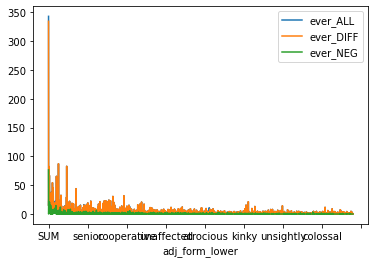

In [13]:
from utils import transform_counts
transform_counts(ever, 'sqrt').plot()

### Items that did not appear _with_  direct negation 

= not in negated frequency table, `neg_frq`

(_in this sample_)

In [14]:
def show_items(index_selection, header):
    if any(index_selection):
        print_iter(index_selection, header=header , indent=2)
    else: 
        print(header, ' 🚫 N/A', sep='\n')

In [15]:
adj_never_neg = all_frq.index[~all_frq.index.isin(neg_frq.index)]
show_items(adj_never_neg, header='Adjectives not appearing in negated frequency data')


Adjectives not appearing in negated frequency data
  ▸ evolving
  ▸ earliest
  ▸ northerly
  ▸ southerly
  ▸ chopped
  ▸ away
  ▸ marrow
  ▸ worldwide


In [16]:
adv_never_neg = all_frq.columns[~all_frq.columns.isin(neg_frq.columns)]
show_items(adv_never_neg, header='Adverbs not appearing in negated frequency data')


Adverbs not appearing in negated frequency data
  ▸ yearly
  ▸ sparsely
  ▸ legendarily
  ▸ second-most


In [17]:
all_frq.loc[adj_never_neg.to_list() + ['SUM'], adv_never_neg.to_list() + ['SUM']]

adv_form_lower,yearly,sparsely,legendarily,second-most,SUM
adj_form_lower,,,,,
evolving,0,0,0,0,3141
earliest,0,0,0,0,2199
northerly,0,0,0,0,1890
southerly,0,0,0,0,1426
chopped,0,0,0,0,1293
away,0,0,0,0,1291
marrow,0,0,0,0,1168
worldwide,10,0,0,0,963
SUM,2218,1281,981,869,83284343


In [18]:
neg_frq.loc[neg_frq.index.isin(adj_never_neg.to_list() + ['SUM']), neg_frq.columns.isin(adv_never_neg.to_list() + ['SUM'])]

adv_form_lower,SUM
adj_form_lower,
SUM,3151853


### Items that did not appear _without_  direct negation 

= not appearing in the "difference" frequency table, `frq_diff`

#### spoiler: 🚫 There are none.

In [19]:
adj_always_neg =neg_frq.index[~neg_frq.index.isin(frq_diff.index)]
header='Adjectives ONLY appearing in negated frequency data'
show_items(adj_always_neg, header)

Adjectives ONLY appearing in negated frequency data
 🚫 N/A


In [20]:
adv_always_neg = neg_frq.columns[~neg_frq.columns.isin(frq_diff.columns)]
show_items(adv_always_neg, header='Adverbs ONLY appearing in negated frequency data')

Adverbs ONLY appearing in negated frequency data
 🚫 N/A


In [21]:
frq_dfs = {
    'all': all_frq, 
    'neg': neg_frq, 
    'diff': frq_diff}
for name, neg_frq in frq_dfs.items():
    print_md_table(neg_frq.iloc[:21, :16], title=f'#### Top (20 x 15) collocations in {name.upper()} frequencies')


#### Top (20 x 15) collocations in ALL frequencies
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |        as |       too |    really |      much |    pretty |      less |       n't |      even |      also |     quite |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| SUM              | 83,284,343 | 9,913,432 | 9,320,997 | 7,568,812 | 5,735,964 | 4,415,785 | 3,709,914 | 3,557,440 | 2,096,057 | 1,986,728 | 1,621,748 | 1,256,870 | 1,206,294 | 1,120,205 | 1,108,517 | 1,065,022 |
| many             |  2,210,387 |    21,237 |       373 |       140 | 1,191,864 |    58,442 |   434,631 |   450,194 |       518 |       201 |        54 |        54 |       580 |     5,310 |     1,132 |       230 |
| important        |  2,199,447 |   359,610 |   306,604 |   748,533 |   105,509 |    17,351 


#### Top (20 x 15) collocations in ALL frequencies
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |        as |       too |    really |      much |    pretty |       n't |      less |    also |    even |   quite |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|--------:|--------:|
| SUM              | 70,327,047 | 8,436,345 | 7,819,673 | 6,395,017 | 4,812,028 | 3,840,892 | 3,093,786 | 2,969,144 | 1,781,001 | 1,680,689 | 1,368,706 | 1,048,833 | 1,045,334 | 947,075 | 943,868 | 911,146 |
| many             |  1,874,118 |    18,119 |       316 |       119 | 1,008,973 |    50,876 |   371,918 |   377,783 |       449 |       179 |        44 |       522 |        46 |     997 |   4,547 |     195 |
| important        |  1,865,709 |   308,346 |   255,636 |   634,415 |    89,826 |    15,086 |    86,041 |    10,625 |    61,297 |     1,588 |     5,573 |     6,222 |    20,968 |  57,805 |     568 |   4,919 |
| good             |  1,709,415 |   428,935 |    16,164 |     4,463 |   128,935 |    83,590 |   195,624 |    49,932 |   220,399 |    12,418 |   201,480 |    29,692 |     2,141 |  17,432 |   1,973 |  23,669 |
| much             |  1,467,369 |    34,752 |        95 |        19 |   506,278 |    57,707 |   289,467 |   481,872 |     2,620 |       239 |    48,249 |    11,936 |        11 |     343 |     852 |      72 |
| likely           |    882,760 |    30,480 |   419,717 |   162,341 |       710 |    40,632 |    25,779 |       988 |       401 |       219 |     1,103 |    15,518 |   116,540 |  14,062 |     716 |   6,254 |
| more             |    859,811 |        60 |     1,962 |        77 |     2,577 |    15,315 |     2,481 |        44 |     3,799 |   301,614 |        12 |       614 |       799 |   2,271 | 168,183 |      61 |
| different        |    760,442 |   196,457 |    10,179 |     1,170 |    33,004 |     3,500 |     7,737 |     4,436 |     5,499 |    36,708 |     1,823 |       697 |       175 |   3,180 |     282 |  36,462 |
| available        |    744,531 |       342 |     8,241 |     1,187 |       411 |   115,806 |     1,634 |       232 |       468 |       866 |        26 |    18,188 |     1,652 |  98,794 |   1,900 |      99 |
| sure             |    728,307 |     4,038 |     1,946 |       259 |    29,425 |   406,007 |     3,257 |     7,483 |    17,187 |       290 |    72,471 |    80,631 |     1,891 |   1,756 |  12,607 |  30,816 |
| difficult        |    701,899 |   158,763 |   183,813 |    64,518 |    22,336 |    17,208 |    13,406 |    23,584 |    15,956 |       555 |     4,822 |     5,029 |     4,702 |   3,564 |     671 |  13,384 |
| popular          |    701,259 |    76,951 |    59,116 |   339,754 |    35,843 |     3,964 |    12,622 |     1,781 |     4,269 |     1,124 |     2,781 |     1,560 |     7,346 |   6,105 |     244 |  10,066 |
| easy             |    658,385 |   108,078 |     4,810 |     1,057 |    75,305 |    83,162 |    62,293 |    33,970 |    25,437 |       703 |    27,188 |    32,766 |     1,531 |   8,541 |     447 |  15,783 |
| better           |    628,143 |        81 |     1,515 |        57 |       761 |    11,761 |     1,713 |        22 |     1,487 |   250,486 |        12 |     1,583 |        82 |   2,387 | 118,059 |     147 |
| high             |    492,287 |   117,647 |     4,495 |     8,962 |    29,197 |     5,023 |    55,775 |    65,352 |     9,369 |       500 |    10,902 |     2,058 |       440 |   4,303 |     223 |   8,762 |
| common           |    474,057 |    39,385 |    72,148 |   234,272 |    12,690 |     6,192 |     9,389 |     8,815 |     1,320 |       788 |     6,161 |     1,159 |    13,945 |   5,365 |     189 |  12,314 |
| bad              |    467,691 |    42,664 |     7,122 |       616 |    74,758 |    39,259 |    59,032 |    69,617 |    41,485 |     1,471 |    17,226 |    17,348 |     1,489 |   1,283 |     434 |   1,576 |
| effective        |    452,579 |    43,565 |   120,815 |   127,834 |     9,404 |     6,590 |    23,481 |       500 |     3,865 |       450 |     1,760 |     1,849 |    14,698 |   3,425 |     250 |   4,087 |
| happy            |    449,759 |   122,742 |     4,980 |     2,372 |    68,015 |    41,696 |     9,876 |    13,896 |    32,519 |       474 |    10,728 |    17,536 |     2,661 |   5,746 |     523 |  12,144 |
| interesting      |    421,480 |    92,240 |    93,437 |    72,000 |    11,775 |     2,510 |     6,594 |       940 |    36,498 |       684 |    10,180 |     1,311 |     5,514 |   8,245 |     395 |  10,929 |
| clear            |    417,442 |    79,359 |    12,788 |     1,283 |    10,209 |    79,847 |    11,298 |     2,182 |     4,871 |       469 |    25,167 |    16,719 |     8,312 |   6,057 |   1,468 |  17,334 |

#### Top (20 x 15) collocations in NEG frequencies
| adj_form_lower   |       SUM |      as |      so |     too |    very |    more |    that |   only |   always |   really |   quite |   even |   entirely |   immediately |   particularly |   much |
|:-----------------|----------:|--------:|--------:|--------:|--------:|--------:|--------:|-------:|---------:|---------:|--------:|-------:|-----------:|--------------:|---------------:|-------:|
| SUM              | 2,649,404 | 438,666 | 284,181 | 261,494 | 161,732 | 138,344 | 137,440 | 94,322 |   87,604 |   80,950 |  65,701 | 65,583 |     52,514 |        52,287 |         45,674 | 44,163 |
| good             |   111,109 |  37,644 |  15,217 |   3,040 |  25,444 |      29 |   8,922 |  2,845 |    1,412 |    2,141 |   1,145 |    572 |         75 |             5 |          1,986 |  1,252 |
| sure             |   108,832 |     579 |  21,781 |   6,953 |     590 |     120 |     246 |     22 |      974 |   15,295 |  22,187 | 12,341 |     11,246 |           128 |             69 |     18 |
| bad              |    88,598 |  23,232 |  17,874 |  16,741 |     268 |       5 |  13,934 |    594 |      771 |      609 |      82 |     97 |        231 |             2 |            268 |     44 |
| easy             |    73,916 |  19,718 |  14,741 |   1,015 |   2,370 |     128 |   8,522 |  1,148 |   20,835 |      461 |     172 |     69 |         86 |            22 |            451 |     79 |
| clear            |    63,070 |   2,926 |   2,678 |     400 |   2,268 |   1,128 |     415 |     95 |    3,365 |    1,283 |   1,924 |  1,329 |      6,276 |        23,181 |            197 |     14 |
| available        |    49,432 |     289 |      53 |      32 |      25 |      81 |       9 |    497 |    2,002 |      217 |      45 |    670 |          8 |        19,999 |              1 |     32 |
| important        |    42,290 |  10,247 |   2,900 |     600 |   1,584 |  12,917 |   4,693 |  2,383 |      119 |    1,129 |      31 |    144 |         11 |            11 |            365 |     81 |
| much             |    39,559 |   4,659 |  17,289 |  10,623 |     965 |       0 |   4,126 |     32 |       10 |    1,067 |       1 |    157 |          0 |             0 |              2 |      4 |
| different        |    37,739 |     502 |   4,769 |   2,047 |   2,714 |   5,519 |   5,358 |    261 |       11 |      298 |      61 |      6 |        218 |             0 |             97 |  9,067 |
| great            |    28,176 |   4,809 |   8,191 |   1,127 |     332 |       5 |   9,458 |    941 |      522 |      330 |      69 |     26 |         15 |             1 |            328 |     14 |
| hard             |    26,085 |     949 |   3,847 |   8,687 |   1,447 |       7 |   8,383 |    254 |       49 |      466 |      35 |    127 |         11 |             0 |            267 |     31 |
| big              |    25,951 |   9,032 |   1,760 |   5,524 |   2,086 |       3 |   5,220 |    140 |       43 |      489 |     296 |     75 |          1 |             0 |            151 |     10 |
| simple           |    25,512 |  12,408 |   5,552 |     206 |     225 |     391 |   4,902 |    216 |      530 |       95 |      72 |      6 |         19 |             1 |             16 |     15 |
| difficult        |    25,477 |   3,952 |   2,243 |   6,406 |   2,071 |   1,389 |   4,720 |    454 |       34 |      254 |      30 |     39 |         26 |             0 |            723 |    158 |
| close            |    24,821 |   2,355 |   1,299 |   1,600 |     862 |      12 |     437 |     88 |       48 |      468 |     109 | 15,099 |          5 |             3 |            529 |      7 |
| happy            |    24,771 |   1,466 |   2,592 |   6,216 |   3,721 |   1,018 |     648 |    184 |      506 |    1,196 |     344 |     59 |      1,011 |             2 |            694 |     39 |
| late             |    22,301 |       7 |      73 |  21,927 |      42 |       2 |       7 |     26 |        7 |       19 |       3 |     22 |          0 |             0 |              4 |      0 |
| true             |    21,914 |     384 |     422 |       7 |      93 |   1,683 |     185 |    539 |    2,498 |    1,413 |   1,598 |    433 |      3,141 |             1 |             33 |     15 |
| ready            |    20,479 |     342 |     236 |      50 |      20 |     234 |      20 |    214 |      208 |      892 |   8,626 |    341 |        110 |            37 |             11 |      3 |
| strong           |    20,127 |  10,982 |   1,292 |   1,550 |   1,776 |      16 |   1,159 |    256 |       81 |      137 |     237 |     46 |          1 |             0 |            558 |     16 |

#### Top (20 x 15) collocations in DIFF frequencies
| adj_form_lower   |        SUM |   abnormally |   about |   above |   absolute |   absolutely |   absurdly |   abundantly |   abysmally |   academically |   accidentally |   accurately |   achingly |   acoustically |   actively |   actually |
|:-----------------|-----------:|-------------:|--------:|--------:|-----------:|-------------:|-----------:|-------------:|------------:|---------------:|---------------:|-------------:|-----------:|---------------:|-----------:|-----------:|
| 3d               |      1,018 |            0 |       0 |       0 |          0 |            0 |          0 |            0 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |         14 |
| SUM              | 67,677,643 |        9,553 |  61,188 |   2,601 |        756 |      297,935 |      8,367 |       12,772 |       1,146 |          6,276 |            829 |          759 |      3,853 |            885 |      5,777 |    123,119 |
| abhorrent        |      2,153 |            0 |       0 |       0 |          0 |          140 |          1 |            0 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |          1 |
| able             |    355,243 |            7 |      98 |       2 |          1 |           68 |          0 |           36 |           0 |            103 |              0 |           27 |          0 |              0 |          7 |      3,311 |
| abnormal         |      3,209 |            0 |       1 |       0 |          0 |           19 |          0 |            1 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |         12 |
| above            |      1,203 |            0 |       1 |       0 |          0 |            4 |          0 |            0 |           0 |              1 |              0 |            0 |          0 |              0 |          0 |          2 |
| abrasive         |      3,349 |            0 |       0 |       0 |          0 |            1 |          1 |            0 |           1 |              0 |              0 |            0 |          0 |              0 |          0 |          3 |
| abrupt           |      3,051 |            0 |       1 |       0 |          0 |            1 |          1 |            0 |           0 |              0 |              0 |            0 |          1 |              0 |          0 |          0 |
| absent           |     26,942 |            0 |       5 |       1 |          0 |           29 |          0 |            1 |           0 |              0 |              0 |            0 |          5 |              0 |          0 |         36 |
| absolute         |      5,271 |            0 |      30 |       0 |          0 |           12 |          0 |            1 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |          4 |
| absorbent        |      2,894 |            0 |       0 |       0 |          0 |            0 |          0 |            0 |           0 |              0 |              0 |            0 |          0 |              3 |          0 |          0 |
| absorbing        |      1,176 |            0 |       0 |       0 |          0 |           18 |          0 |            0 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |          0 |
| abstract         |     10,695 |            0 |       0 |       0 |          0 |           12 |          6 |            1 |           0 |              0 |              1 |            0 |          0 |              0 |          0 |          3 |
| absurd           |     20,812 |            1 |       5 |       0 |          3 |          908 |          2 |            0 |           0 |              3 |              1 |            1 |          0 |              0 |          1 |         22 |
| abundant         |     17,918 |            8 |       4 |       0 |          1 |           17 |          3 |            3 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |         15 |
| abused           |      1,120 |            0 |       0 |       0 |          0 |            0 |          0 |            0 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |          0 |
| abusive          |     10,406 |            2 |       0 |       0 |          0 |           10 |          1 |            0 |           0 |              0 |              0 |            0 |          0 |              0 |          8 |         18 |
| abysmal          |      1,674 |            0 |       0 |       0 |          0 |          173 |          0 |            0 |           1 |              0 |              0 |            0 |          0 |              0 |          0 |          1 |
| academic         |      6,743 |            0 |       2 |       0 |          0 |            0 |          1 |            0 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |          1 |
| acceptable       |     62,114 |            1 |      45 |       3 |          1 |          104 |          0 |            1 |           0 |             70 |              0 |            1 |          0 |              1 |          0 |         55 |
| accepting        |        708 |            0 |       0 |       0 |          0 |            0 |          0 |            0 |           0 |              0 |              0 |            0 |          0 |              0 |          0 |          0 |


### How about the bigrams considered as a unit?

There are both adverbs and adjectives that didn't make an appearance in the negated data, 
but this could easily be due to the large disparity size of the dataframes. 
So I would be incredibly hesitant to say they are sensitive to polarity (and prefer _positive polarity_). 



Total Tokens per Frequency Group
|      |     totals |
|:-----|-----------:|
| ALL  | 70,327,047 |
| NEG  |  2,649,404 |
| DIFF | 67,677,643 |

Marginal Frequencies for ALL Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,858 |                     991 |
| mean  |                  18,229 |                  70,966 |
| std   |                  77,644 |                 495,355 |
| min   |                     732 |                     735 |
| 25%   |                   1,370 |                   1,433 |
| 50%   |                   2,950 |                   3,414 |
| 75%   |                   9,030 |                  13,574 |
| max   |               1,874,118 |               8,436,345 |

Marginal Frequencies for NEG Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,845 |                     986 |
| mean  |                     689 |                   2,687 |
| std   |                   4,038 |                  21,379 |
| min   |                       1 |                       1 |
| 25%   |                      29 |                      14 |
| 50%   |                      74 |                      42 |
| 75%   |                     253 |                     178 |
| max   |                 111,109 |                 438,666 |

Marginal Frequencies for DIFF Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,845 |                     986 |
| mean  |                  35,197 |                  68,633 |
| std   |               1,093,714 |                 483,583 |
| min   |                     652 |                     598 |
| 25%   |                   1,347 |                   1,412 |
| 50%   |                   2,871 |                   3,392 |
| 75%   |                   8,777 |                  13,216 |
| max   |              67,677,643 |               8,274,613 |


In [22]:
totals = pd.Series({name.upper(): frq_df.loc['SUM', 'SUM'] 
                    for name, frq_df in frq_dfs.items()}
                   ).to_frame('totals')
print_md_table(totals, title='Total Tokens per Frequency Group')

for name, neg_frq in frq_dfs.items():
    print_md_table(neg_frq['SUM'].iloc[1:].describe().to_frame('individual adj totals').join(
        neg_frq.T['SUM'].iloc[1:].describe().to_frame('individual adv totals')), 
                   title=f'Marginal Frequencies for {name.upper()} Bigram Tokens')


Total Tokens per Frequency Group
|      |     totals |
|:-----|-----------:|
| ALL  | 83,284,343 |
| NEG  |  3,151,853 |
| DIFF | 80,132,490 |

Marginal Frequencies for ALL Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                  21,388 |                  82,870 |
| std   |                  91,460 |                 581,924 |
| min   |                     870 |                     868 |
| 25%   |                   1,637 |                   1,705 |
| 50%   |                   3,466 |                   4,049 |
| 75%   |                  10,673 |                  15,767 |
| max   |               2,210,387 |               9,913,432 |

Marginal Frequencies for NEG Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |               

In [29]:
def get_ratio(df, transpose=False):
    all_vals = all_frq.transpose() if transpose else all_frq
    return df.apply(lambda c: c / all_vals['SUM']).sort_values('SUM', ascending=False).sort_values('SUM',axis=1, ascending=False)

In [30]:
def get_totals_frame(neg_frq, frq_diff, transpose=False):
    if transpose: 
        neg_frq= neg_frq.transpose()
        frq_diff= frq_diff.transpose()
        
    neg_ratio_frq = get_ratio(neg_frq, transpose=transpose)
    diff_ratio_frq = get_ratio(frq_diff, transpose=transpose)

    totals_df=neg_ratio_frq['SUM'].to_frame('NEG/ALL')
    totals_df['DIFF/ALL'] = diff_ratio_frq['SUM']
    totals_df['NEG_RAW'] = neg_frq['SUM']
    totals_df['DIFF_RAW'] = frq_diff['SUM']
    return totals_df

In [31]:
adj_totals = get_totals_frame(neg_frq, frq_diff, transpose=False)
adj_totals.head(15)

,NEG/ALL,DIFF/ALL,NEG_RAW,DIFF_RAW
adj_form_lower,,,,
shabby,0.695467,0.304533,5538.0,2425.0
farfetched,0.321469,0.678531,569.0,1201.0
clear-cut,0.311830,0.688170,1368.0,3019.0
rosy,0.311478,0.688522,2076.0,4589.0
far-fetched,0.288329,0.711671,1969.0,4860.0
dissimilar,0.287635,0.712365,2524.0,6251.0
cut,0.248708,0.751292,385.0,1163.0
binding,0.243320,0.756680,683.0,2124.0
hasty,0.235318,0.764682,589.0,1914.0


In [32]:
adv_totals = get_totals_frame(neg_frq, frq_diff, transpose=True)
adv_totals.head(15)

,NEG/ALL,DIFF/ALL,NEG_RAW,DIFF_RAW
adv_form_lower,,,,
necessarily,0.758991,0.241009,41047.0,13034.0
exactly,0.706662,0.293338,42028.0,17446.0
that,0.662606,0.337394,165334.0,84187.0
immediately,0.564880,0.435120,57145.0,44018.0
yet,0.534997,0.465003,51891.0,45102.0
terribly,0.262328,0.737672,17875.0,50265.0
remotely,0.257521,0.742479,5513.0,15895.0
only,0.246698,0.753302,110007.0,335910.0
altogether,0.225067,0.774933,4421.0,15222.0


In [ ]:
from utils import transform_counts

- [ ] add code to import `transform_counts` using `sqrt`